# Setup

Following analyses are produced in Python 2.7.12 using Jupyter notebook. Versions of each Python module will be indicated in the notebook whenever installed.

# Modules

In [53]:
from StringIO import StringIO
import pandas as pd
import requests as rq
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

import plotly.plotly as py

from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_predict

In [54]:
print pd.__version__
print rq.__version__
print np.__version__

0.18.1
2.14.1
1.12.1


# Dataset

The dataset is the Breast Cancer Wisconsin Dataset, downloaded from UC Irvine Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original)).

Our goal is to develop a classification model that predicts whether a biopsied breast cell is benign (not harmful) or malignant (cancerous), given a set of attributes (features) about cells (observations). These features were generated from image analysis of fine needle aspiration of breast masses (https://en.wikipedia.org/wiki/Fine-needle_aspiration).

- Sample ID (code number)
- Clump thickness
- Uniformity of cell size
- Uniformity of cell shape
- Marginal adhesion
- Single epithelial cell size
- Number of bare nuclei
- Bland chromatin
- Number of normal nuclei
- Mitosis
- Classes, i.e. diagnosis

In [3]:
url ="https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
s=rq.get(url).text
data=pd.DataFrame.from_csv(StringIO(s), index_col=False)

In [4]:
data.shape # 698 observations and 10 features

(698, 11)

Add column names

In [5]:
data.columns = ['Id', 
                'Clump_Thickness', 
                'Uniformity_Cell_Size', 
                'Uniformity_Cell_Shape', 
                'Marginal_Adhesion', 
                'Single_Epithelial_Cell_Size', 
                'Bare_Nuclei', 
                'Bland_Chromatin', 
                'Normal_Nucleoli', 
                'Mitoses', 
                'Class']

In [6]:
data.head() 
# There are 9 cell features (exc. id_number) in 2 classes ("values = 2 (benign) or 4 (malignant)")

,Id,Clump_Thickness,Uniformity_Cell_Size,Uniformity_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,1002945,5,4,4,5,7,10,3,2,1,2
1,1015425,3,1,1,1,2,2,3,1,1,2
2,1016277,6,8,8,1,3,4,3,7,1,2
3,1017023,4,1,1,3,2,1,3,1,1,2
4,1017122,8,10,10,8,7,10,9,7,1,4


Fix Id column

In [7]:
data.index = data.Id 
data.drop('Id', axis=1)[1:10]

,Clump_Thickness,Uniformity_Cell_Size,Uniformity_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
Id,,,,,,,,,,
1015425,3,1,1,1,2,2,3,1,1,2
1016277,6,8,8,1,3,4,3,7,1,2
1017023,4,1,1,3,2,1,3,1,1,2
1017122,8,10,10,8,7,10,9,7,1,4
1018099,1,1,1,1,2,10,3,1,1,2
1018561,2,1,2,1,2,1,3,1,1,2
1033078,2,1,1,1,2,1,1,1,5,2
1033078,4,2,1,1,2,1,2,1,1,2
1035283,1,1,1,1,1,1,3,1,1,2


In [8]:
data.describe()

,Id,Clump_Thickness,Uniformity_Cell_Size,Uniformity_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
count,6.980000e+02,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000
mean,1.071807e+06,4.416905,3.137536,3.210602,2.809456,3.217765,3.438395,2.869628,1.590258,2.690544
std,6.175323e+05,2.817673,3.052575,2.972867,2.856606,2.215408,2.440056,3.055004,1.716162,0.951596
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.702582e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238354e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


# Missing and/or Duplicated Data

Bare_Nuclei cell feature is missing. Why? Most features are intergers with the exception of 'Bare Nuclei', an object.

In [9]:
data.dtypes 

Id                              int64
Clump_Thickness                 int64
Uniformity_Cell_Size            int64
Uniformity_Cell_Shape           int64
Marginal_Adhesion               int64
Single_Epithelial_Cell_Size     int64
Bare_Nuclei                    object
Bland_Chromatin                 int64
Normal_Nucleoli                 int64
Mitoses                         int64
Class                           int64
dtype: object

In [10]:
data.Bare_Nuclei.value_counts() 

1     401
10    132
5      30
2      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: Bare_Nuclei, dtype: int64

There are 16 '?' values - some cell types were bare nuclei could NOT be assessed, they were removed

In [11]:
data = data[data.Bare_Nuclei != '?']
data.Bare_Nuclei.value_counts()

1     401
10    132
5      30
2      30
3      28
8      21
4      19
9       9
7       8
6       4
Name: Bare_Nuclei, dtype: int64

In [12]:
data.Bare_Nuclei = map(int,data.Bare_Nuclei)

In [13]:
data.dtypes

Id                             int64
Clump_Thickness                int64
Uniformity_Cell_Size           int64
Uniformity_Cell_Shape          int64
Marginal_Adhesion              int64
Single_Epithelial_Cell_Size    int64
Bare_Nuclei                    int64
Bland_Chromatin                int64
Normal_Nucleoli                int64
Mitoses                        int64
Class                          int64
dtype: object

The dataset is made of 682 observations with 11 features, without any missing values.

In [14]:
data.shape

(682, 11)

In [15]:
pd.isnull(data).sum()

Id                             0
Clump_Thickness                0
Uniformity_Cell_Size           0
Uniformity_Cell_Shape          0
Marginal_Adhesion              0
Single_Epithelial_Cell_Size    0
Bare_Nuclei                    0
Bland_Chromatin                0
Normal_Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64

The dataset has duplicated observations that were removed. The final dataset is now made of 674 observations.

In [16]:
data[data.duplicated()]

,Id,Clump_Thickness,Uniformity_Cell_Size,Uniformity_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
Id,,,,,,,,,,,
1218860,1218860,1,1,1,1,1,1,3,1,1,2
1100524,1100524,6,10,10,2,8,10,7,3,3,4
1116116,1116116,9,10,10,1,10,8,3,3,1,4
1198641,1198641,3,1,1,1,2,1,3,1,1,2
320675,320675,3,3,5,2,3,10,7,1,1,4
704097,704097,1,1,1,1,1,1,2,1,1,2
1321942,1321942,5,1,1,1,2,1,3,1,1,2
466906,466906,1,1,1,1,2,1,1,1,1,2


In [17]:
data = data.drop_duplicates()

In [18]:
data.shape

(674, 11)

-

# Exploratory Data Analysis

The dataset is not well balanced - 438 benign cells and 236 malignant cells.

In [19]:
data.groupby('Class').count()

,Id,Clump_Thickness,Uniformity_Cell_Size,Uniformity_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses
Class,,,,,,,,,,
2,438,438,438,438,438,438,438,438,438,438
4,236,236,236,236,236,236,236,236,236,236


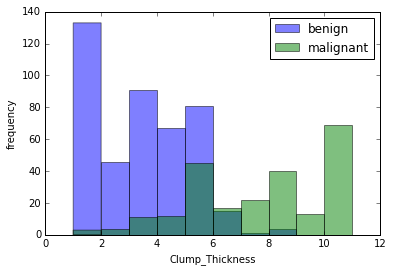

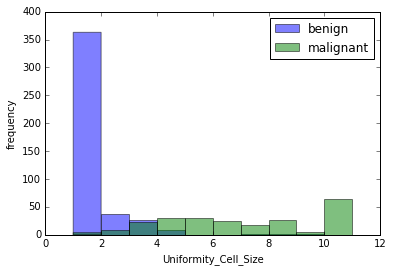

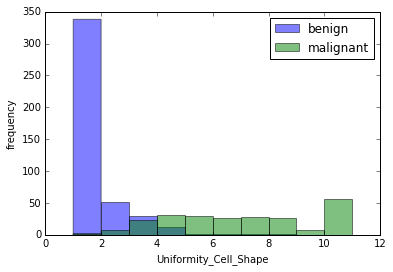

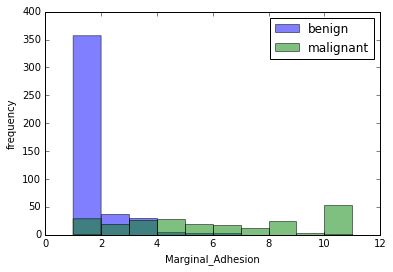

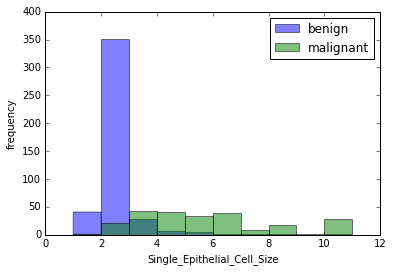

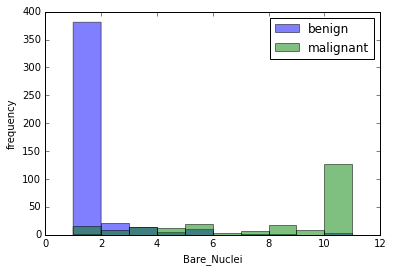

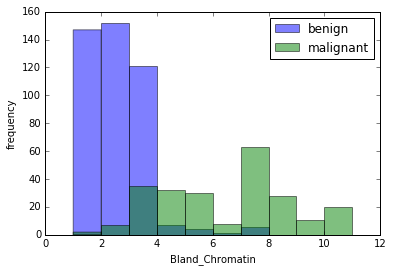

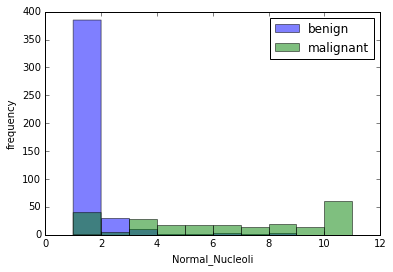

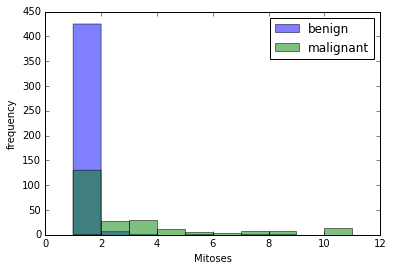

In [20]:
data.iloc[:,1:11]
bins = range(1,12,1)

for i, feature in enumerate(data.iloc[:,1:10]):
    plt.subplots()
    plt.hist(data[data['Class'] == 2][feature], bins = bins, alpha = 0.5, label='benign')  
    plt.hist(data[data['Class'] == 4][feature], bins = bins, alpha = 0.5, label='malignant')
    plt.ylabel('frequency')
    plt.xlabel(feature)
    plt.legend(loc='upper right')

Observations:
- Many benign cells are highly skewed towards lower scores (1-3) -- in comparison to malignant cells that score across the range (1-10). 
- Most cells can be distinguished through those differences. 

Which features are correlated?

In [21]:
import seaborn as sns

In [22]:
subdata = data.iloc[:,1:10]
subdata.columns

Index([u'Clump_Thickness', u'Uniformity_Cell_Size', u'Uniformity_Cell_Shape',
       u'Marginal_Adhesion', u'Single_Epithelial_Cell_Size', u'Bare_Nuclei',
       u'Bland_Chromatin', u'Normal_Nucleoli', u'Mitoses'],
      dtype='object')

From the correlogram, Cell shape and size are highly correlated. Other features (with the exception of mitoses) are moderately correlated. 

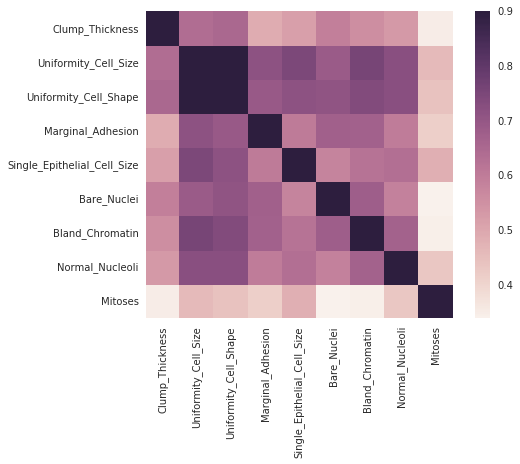

In [23]:
# Compute the correlation matrix
corrmat = subdata.corr()

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.9, square=True)

How does the correlation between cell shape and size look like?

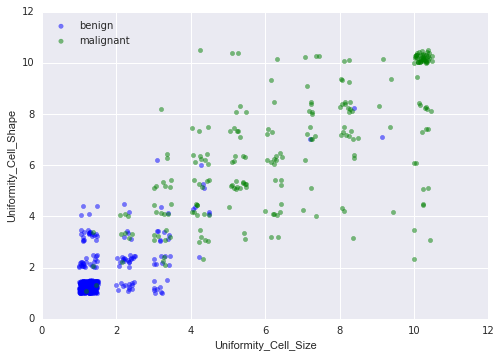

In [24]:
b_len = len(data[data['Class'] == 2]['Uniformity_Cell_Shape'])
m_len = len(data[data['Class'] == 4]['Uniformity_Cell_Shape'])
b_x = data[data['Class'] == 2]['Uniformity_Cell_Size'] + np.random.rand(b_len)/2.0
b_y = data[data['Class'] == 2]['Uniformity_Cell_Shape'] + np.random.rand(b_len)/2.0
m_x = data[data['Class'] == 4]['Uniformity_Cell_Size'] + np.random.rand(m_len)/2.0
m_y = data[data['Class'] == 4]['Uniformity_Cell_Shape'] + np.random.rand(m_len)/2.0

plt.scatter(b_x, b_y,color = 'b', alpha = 0.5, label='benign')
plt.scatter(m_x, m_y,color = 'g', alpha = 0.5, label='malignant')
plt.xlabel('Uniformity_Cell_Size')
plt.ylabel('Uniformity_Cell_Shape')
plt.legend(loc='upper left');

Most benign cells are grouped in the left-bottom corner of this scatterplot which can explain most of the correlation. They displayed low scores (1-3) for both cell features, size and shape. 

-

# Building Models

In terms of models, the dataset is an example for binary classifiers - binomial logistic regression, tree-based methods (CART, Random Forest and XGBoost), k-nearest neighbors and support vector machine.

In [25]:
data_x = data.iloc[:,1:10]
data_y = data['Class']

In [26]:
data_x.columns

Index([u'Clump_Thickness', u'Uniformity_Cell_Size', u'Uniformity_Cell_Shape',
       u'Marginal_Adhesion', u'Single_Epithelial_Cell_Size', u'Bare_Nuclei',
       u'Bland_Chromatin', u'Normal_Nucleoli', u'Mitoses'],
      dtype='object')

We first correct the unbalanced dataset by under sampling the 'benign' class leading to a binary dataset with equal number of observations, 236.


In [27]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
data_x_balanced, data_y_balanced = rus.fit_sample(data_x, data_y)

In [28]:
from collections import Counter
Counter(data_y_balanced)

Counter({2: 236, 4: 236})

Training & Test sets

In [29]:
from sklearn.cross_validation import train_test_split
train_x, test_x, train_y, test_y = train_test_split(data_x_balanced, data_y_balanced, test_size = 0.25)
train_x.shape # 354 cells and 9 features
test_x.shape #  118 cells and 9 features

(118, 9)

Models
1. Logistic Regression
2. Linear Discriminant Analysis
3. Decision Tree CART
4. Random Forest 
5. Gradient Boosting
6. K-Nearest Neighbors
7. Naive Bayes
8. Support Vector Machines

In [30]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [34]:
seed = 123
models = []
models.append(('logreg', LogisticRegression()))
models.append(('cart', DecisionTreeClassifier()))
models.append(('rfc', RandomForestClassifier()))
models.append(('gbc', GradientBoostingClassifier()))
models.append(('knn', KNeighborsClassifier()))
models.append(('lda', LinearDiscriminantAnalysis()))
models.append(('nb', GaussianNB()))
models.append(('svc', SVC(kernel='rbf')))

In [35]:
seed = 123
results = []
names = []
scoring = 'accuracy'
print("10-fold CV Train Accuracy:")
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_scores = model_selection.cross_val_score(model, train_x, train_y, cv=kfold, scoring=scoring)
    results.append(cv_scores)
    names.append(name)
    msg = "  %s: %0.2f (+/- %0.2f)" % (name, cv_scores.mean()*100, cv_scores.std()*100)
    print(msg)

10-fold CV Train Accuracy:
  logreg: 97.44 (+/- 2.37)
  cart: 95.18 (+/- 2.85)
  rfc: 97.17 (+/- 2.19)
  gbc: 97.45 (+/- 1.53)
  knn: 96.87 (+/- 3.49)
  lda: 96.30 (+/- 4.04)
  nb: 97.44 (+/- 2.37)
  svc: 96.60 (+/- 2.48)


Boxplot model comparison

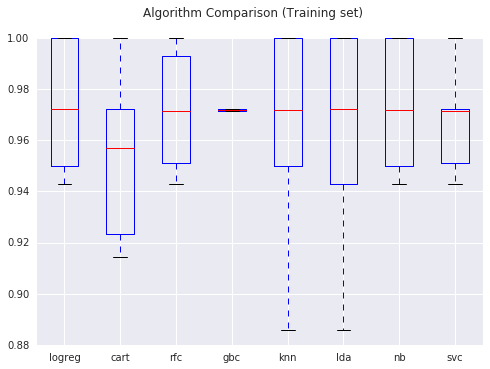

In [36]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison (Training set)')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

!!! Measuring algoritm performance with other metrics - confusion matrix and statistics

In [37]:
seed =123
results = []
names = []
scores = 'accuracy'
print("10-fold CV Test Accuracy:")
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_preds = model_selection.cross_val_predict(model, test_x, test_y, cv=kfold)
    names.append(name)
    print ("  %s: %0.2f" % (name, metrics.accuracy_score(test_y, cv_preds)*100))

10-fold CV Test Accuracy:
  logreg: 92.37
  cart: 92.37
  rfc: 95.76
  gbc: 92.37
  knn: 95.76
  lda: 94.07
  nb: 96.61
  svc: 95.76


All algorithms performed very well overall. Support Vector Classifier (SVC) slightly outperformed other algorithms with overall 10-fold train accuracy of 98.3% followed by Logistic Regression (LR) then tree-based methods (RFC, GBC) and Nearest Neighbor (KNN). Classification and Regression Tree (CART) method is the least performing algorithm with an overall 10-fold train accurcacy of 93.2% and test accuracy of 90.7%.

# Model Optimisation by Feature Selection

We then proceed to select relevant feature (variable) to guarantee best model performances using 3 different methods
(feature importance, recursive feature elimination). Feature selection is a process where you automatically select those features that contribute most to the outcome you are trying to predict (i.e class). Why? Having irrelevant features in the data can decrease the accuracy of the models. Some of the benefits of feature selection include reduce overfitting, improving accuracy and minimizing computing time. 

- Feature Importance of Tree-based methods

Two of our best performing classifiers (Random Forest RFC, Gradient Boosting GBC) use ensembles of decision trees and compute the relative importance of each feature which can be used to inform a feature selection process.

                             importance
feature                                
Uniformity_Cell_Size              0.340
Bare_Nuclei                       0.215
Uniformity_Cell_Shape             0.170
Single_Epithelial_Cell_Size       0.144
Clump_Thickness                   0.046
Bland_Chromatin                   0.034
Marginal_Adhesion                 0.023
Normal_Nucleoli                   0.023
Mitoses                           0.006


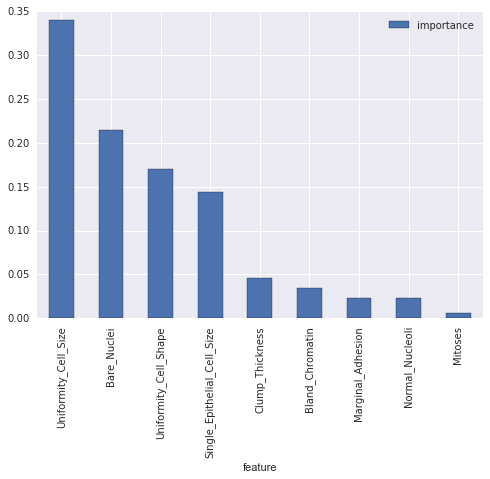

In [38]:
rfc = RandomForestClassifier()
rfc.fit(train_x, train_y)
importances = pd.DataFrame({'feature':data_x.columns,'importance':np.round(rfc.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

print importances
importances.plot.bar()

In [39]:
from numpy import sort
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

model = RandomForestClassifier()
model.fit(train_x, train_y)

# make predictions for test data and evaluate
pred_y = model.predict(test_x)
predictions = [round(value) for value in pred_y]
accuracy = metrics.accuracy_score(test_y, predictions)
print("RFC Accuracy: %.2f%%" % (accuracy * 100.0))

# fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # selecting features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_train_x = selection.transform(train_x)
    
    # training model
    selection_model = RandomForestClassifier()
    selection_model.fit(select_train_x, train_y)
    
    # evaluating model
    select_test_x = selection.transform(test_x)
    pred_y = selection_model.predict(select_test_x)
    predictions = [round(value) for value in pred_y]
    accuracy = metrics.accuracy_score(test_y, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_train_x.shape[1], accuracy*100.0))

RFC Accuracy: 94.92%
Thresh=0.010, n=9, Accuracy: 99.15%
Thresh=0.012, n=8, Accuracy: 95.76%
Thresh=0.013, n=7, Accuracy: 95.76%
Thresh=0.026, n=6, Accuracy: 97.46%
Thresh=0.077, n=5, Accuracy: 94.92%
Thresh=0.109, n=4, Accuracy: 96.61%
Thresh=0.158, n=3, Accuracy: 95.76%
Thresh=0.215, n=2, Accuracy: 90.68%
Thresh=0.380, n=1, Accuracy: 88.98%


Using RFC, the optimal model is obtained with only 4 features and an estimated accuracy of 98.31% compared to 95.76%. A more complex model with 7 features would lead to the same accuracy while a simpler model with only 3 features leads to a decrease in accuracy from 98.31% to 95.76%. These features are, in order of importance,Uniformity_Cell_Shape, Single_Epithelial_Cell_Size, Uniformity_cell_Size, Bare_Nuclei and Bland_Chromatin.

-

                             importance
feature                                
Bare_Nuclei                       0.195
Uniformity_Cell_Shape             0.186
Single_Epithelial_Cell_Size       0.168
Uniformity_Cell_Size              0.115
Marginal_Adhesion                 0.108
Bland_Chromatin                   0.108
Clump_Thickness                   0.069
Normal_Nucleoli                   0.037
Mitoses                           0.014


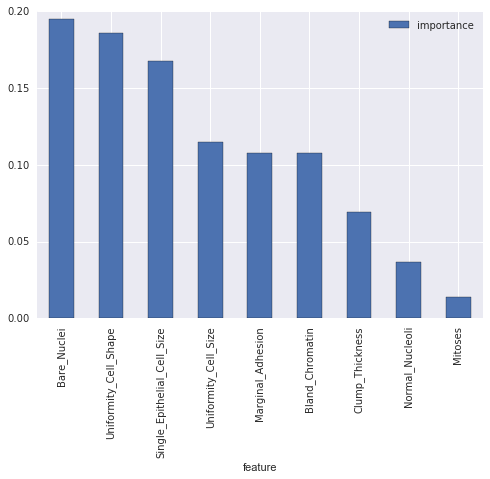

In [40]:
gbc = GradientBoostingClassifier()
gbc.fit(train_x, train_y)
importances = pd.DataFrame({'feature':data_x.columns,'importance':np.round(gbc.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

print importances
importances.plot.bar()

In [41]:
model = GradientBoostingClassifier()
model.fit(train_x, train_y)

# make predictions for test data and evaluate
pred_y = model.predict(test_x)
predictions = [round(value) for value in pred_y]
accuracy = accuracy_score(test_y, predictions)
print("GBC Accuracy: %.2f%%" % (accuracy * 100.0))

# fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_train_x = selection.transform(train_x)
    
    # train model
    selection_model = RandomForestClassifier()
    selection_model.fit(select_train_x, train_y)
    
    # eval model
    select_test_x = selection.transform(test_x)
    pred_y = selection_model.predict(select_test_x)
    predictions = [round(value) for value in pred_y]
    accuracy = accuracy_score(test_y, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_train_x.shape[1], accuracy*100.0))

GBC Accuracy: 96.61%
Thresh=0.014, n=9, Accuracy: 96.61%
Thresh=0.031, n=8, Accuracy: 97.46%
Thresh=0.076, n=7, Accuracy: 96.61%
Thresh=0.093, n=6, Accuracy: 94.07%
Thresh=0.100, n=5, Accuracy: 95.76%
Thresh=0.106, n=4, Accuracy: 96.61%
Thresh=0.182, n=3, Accuracy: 96.61%
Thresh=0.188, n=2, Accuracy: 94.92%
Thresh=0.210, n=1, Accuracy: 88.98%


Comparing model performance with feature importance, the optimal model is obtained with only 6 features and an estimated accuracy of 98.31%. A more complex model with 8 features (leaving 'Bland_chromatin' feature out) would lead to the same accuracy of 98.31% while a simpler model with only 3 features leads to a decrease in accuracy from 98.31% to 97.46%.

- Recursive feature elimination

Recursive Feature Elimination (or RFE) removes recursively features and buils a model on those features that remain.
It uses the model estimated accuracy to identify which feature (or combination of features) contribute the most and rank them.

In [42]:
#Reminder of the set of features in order
data_x.columns

Index([u'Clump_Thickness', u'Uniformity_Cell_Size', u'Uniformity_Cell_Shape',
       u'Marginal_Adhesion', u'Single_Epithelial_Cell_Size', u'Bare_Nuclei',
       u'Bland_Chromatin', u'Normal_Nucleoli', u'Mitoses'],
      dtype='object')

In [43]:
from sklearn.feature_selection import RFE
rfc = RandomForestClassifier()

# create the RFE model and select 4 attributes
rfe_model = RFE(rfc, 4, step=1)
rfe_model = rfe_model.fit(train_x, train_y)

# summarize the selection of the attributes
print(rfe_model.support_)
print(rfe_model.ranking_)

# evaluate the model on testing set
pred_y = rfe_model.predict(test_x)
predictions = [round(value) for value in pred_y]
accuracy = accuracy_score(test_y, predictions)
print("Test Accuracy: %.2f%%" % (accuracy*100.0))

[False  True  True False False  True  True False False]
[3 1 1 5 2 1 1 4 6]
Test Accuracy: 95.76%


In [44]:
gbc = GradientBoostingClassifier()

rfe_model = RFE(gbc, 6, step=1)
rfe_model = rfe_model.fit(train_x, train_y)

print(rfe_model.support_)
print(rfe_model.ranking_)

pred_y = rfe_model.predict(test_x)
predictions = [round(value) for value in pred_y]
accuracy = accuracy_score(test_y, predictions)
print("Test Accuracy: %.2f%%" % (accuracy*100.0))

[False  True  True  True  True  True  True False False]
[2 1 1 1 1 1 1 3 4]
Test Accuracy: 96.61%


A simpler Random Forest classifier would require only 4 features (Uniformity_Cell_Size, Uniformity_Cell_Shape, Single_Epithelial_Cell_Size, Bare_Nuclei) to yield a test accuracy of 96.61%. In contrast, a Gradient Boosting model using 6 features will lead to identical performance. 

In [45]:
from sklearn.feature_selection import RFE

svm = SVC(kernel='linear')

rfe_model = RFE(svm, 7, step=1)
rfe_model = rfe_model.fit(train_x, train_y)

print(rfe_model.support_)
print(rfe_model.ranking_)

pred_y = rfe_model.predict(test_x)
predictions = [round(value) for value in pred_y]
accuracy = accuracy_score(test_y, predictions)
print("Test Accuracy: %.2f%%" % (accuracy*100.0))

[ True  True False  True False  True  True  True  True]
[1 1 2 1 3 1 1 1 1]
Test Accuracy: 96.61%


knn = KNeighborsClassifier()

rfe_model = RFE(knn, 9, step=1)
rfe_model = rfe_model.fit(train_x, train_y)

print(rfe_model.support_)
print(rfe_model.ranking_)

pred_y = rfe_model.predict(test_x)
predictions = [round(value) for value in pred_y]
accuracy = accuracy_score(test_y, predictions)
print("Test Accuracy: %.2f%%" % (accuracy*100.0))

Applying RFE to competing binary classifiers KNN and linear SVM, the results showed that KNN require the complete set of features to perform an estimated test accuracy of 94.92%. In constrast, linear SVM requires 7 features to perform like the aforementioned tree-based methods, leaving 'Bland_Chromatin' and 'Single_Epithelial_Cell_Size' features out.

- Univariate selection

You can use statistical tests to select features that have the strongest relationship with the output variable (i.e. class). Scikit-learn library provides the SelectKBest class to use with a suite of different statistical tests in order to select a specific number of features. The example below uses the chi squared (chi^2) statistical test.

In [46]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

names = ['Clump_Thickness', 'Uniformity_Cell_Size', 'Uniformity_Cell_Shape', 'Marginal_Adhesion', 'Single_Epithelial_Cell_Size', 'Bland_Chromatin', 'Normal_Nucleoli', 'Mitoses']
for n in range(0, len(names)):
    test = SelectKBest(score_func=chi2, k=9)
    fit = test.fit(train_x, train_y)

    print(" %s : %.2f") % (names[n], fit.scores_[n])

 Clump_Thickness : 290.90
 Uniformity_Cell_Size : 608.91
 Uniformity_Cell_Shape : 594.27
 Marginal_Adhesion : 480.20
 Single_Epithelial_Cell_Size : 247.26
 Bland_Chromatin : 843.84
 Normal_Nucleoli : 339.49
 Mitoses : 527.01


The chosen features are the ones with highest scores - the top 3 features are Uniformity_Cell_Size, Uniformity_Cell_Shape and Bland_Chromatin.

# Model Optimisation by Parameter Tuning

In that part, we reviewed the four classifiers kNN, RBF, GBC and SVM and optimized their performances using their respective parameters also called hyperparameters. 

- k-nearest neighbors

k-Nearest Neighbors (kNN) is a non parametric and instance-based learning algorithm meaning that it makes no assumption about the relationship between the cell features (x) and the class (y) and, it memorizes the training observations for the prediction phase.
In the classification setting, the algorithm forms the majority vote between most k similar observations i.e. neighbors (sharing similar cell features) to a given “unseen” observation. Similarity is defined according to a distance metric between two data points where the distance metric commonly considered is the Euclidean distance but other measures include the Manhattan, Chebyshev and Hamming distance. Thus, there are two primary hyperparameters to consider for optimization: the number of neighbors k and the distance metric/similarity function. An excellent tutorial and detailed guide to kNN can be found on Kevin Zakka's blog (kevinzakka.github.io/2016/07/13/k-nearest-neighbor/). Using kNN classifier, we solve the problem similarly to the procedure employed by medical doctors - the test reports from a new patient are compared with the records of other patients (training set) that are known to be either begnin or malignant.


The optimal number of neighbors is 2 with 96.9%


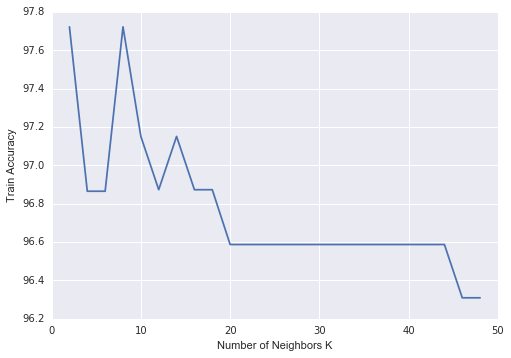

In [51]:
from sklearn import model_selection

#Neighbors
neighbors = filter(lambda x: x % 2 == 0, list(range(1,50)))
#neighbors = range(50)

#Create empty list that will hold cv scores
cv_scores = []

#Perform 10-fold cross validation on training set for odd values of k:
seed=123
for k in neighbors:
    k_value = k+1
    knn = KNeighborsClassifier(n_neighbors = k_value, weights='uniform', p=2, metric='euclidean')
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    scores = model_selection.cross_val_score(knn, train_x, train_y, cv=kfold, scoring='accuracy')
    cv_scores.append(scores.mean()*100)
    #print("k=%d %0.2f (+/- %0.2f)" % (k_value, scores.mean()*100, scores.std()*100))

optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print "The optimal number of neighbors is %d with %0.1f%%" % (optimal_k, cv_scores[optimal_k])

plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Train Accuracy')
plt.show()

The optimal number of neighbors is 2 with 95.8%


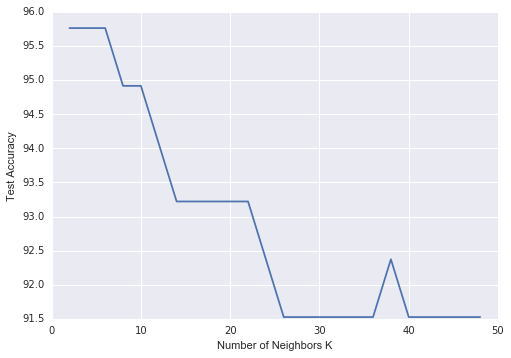

In [52]:
cv_preds = []

#Perform 10-fold cross validation on testing set for odd values of k
seed=123
for k in neighbors:
    k_value = k+1
    knn = KNeighborsClassifier(n_neighbors = k_value, weights='uniform', p=2, metric='euclidean')
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    preds = model_selection.cross_val_predict(knn, test_x, test_y, cv=kfold)
    cv_preds.append(metrics.accuracy_score(test_y, preds)*100)
    #print("k=%d %0.2f" % (k_value, 100*metrics.accuracy_score(test_y, preds)))

optimal_k = neighbors[cv_preds.index(max(cv_preds))]
print "The optimal number of neighbors is %d with %0.1f%%" % (optimal_k, cv_preds[optimal_k])

plt.plot(neighbors, cv_preds)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Test Accuracy')
plt.show()

10-fold cross validation tells us that the best performances (accuracy) of k-nearest neighbors against the training set  and the testing set are for k=2 using uniform weights and euclidean distance, 96.9% and 95.8% respectively.

- Random Forest

Random Forest is one of the 'infamous' tree-based algorithms, popularly used in all kinds of data science problems. Random Forest is defined as an ensemble of decision trees. Decision tree is a type of supervised learning algorithm that splits observations (both categorical and continuous variables) into the classes based on the best splitter (i.e. feature value) at each step  - this is a greedy algorithm. However, decision trees can suffer from high variance (if they are not pruned) which makes their results fragile to the specific training data used. 


http://www.r2d3.us/visual-intro-to-machine-learning-part-1/
Beautiful illustration of a decision tree by Stefanie Yee and Tony Chu (r2d3.us) on NYC and SF home sales.

One way to reduce this variance, called Bootstrap aggregation or Bagging, builds multiple models from observations of your training data. However, the same algorithm is used to create each tree, meaning the same or very similar split points may be chosen in each tree making and the trees would be highly correlated. In addition to bagging, Random Forest also constrains the features that can be used to build the trees, forcing trees to be different leading to a more accurate and stable predictive performance.

There are 4 hyperparameters required for a Random Forest classifier; 
- the number of trees in the forest (n_estimators).
- the number of features to consider at each split. By default: square root of total number of features (max_features).
- the maximum depth of a tree i.e. number of nodes (max_depth).
- the minimum number of samples required to be at a leaf node / bottom of a tree (min_samples_leaf).


In our study, our training set has 354 observations and 9 features. Therefore, our max_features will be 3 at each split (equivalent to use 'sqrt' and 'auto'). For the other 3 hyperparameters, we can screen one parameter at a time (fixing max_depth to 10 and min_samples_leaf=1) and compare the model performance with accuracy or error rate.

The optimal number of estimators is 36 with 97.4%


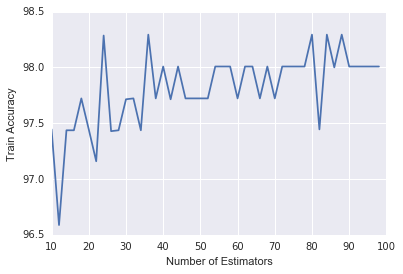

In [98]:
seed = 123
 
# RFC with fixed hyperparameters max_depth, max_features and min_samples_leaf
rfc = RandomForestClassifier(n_jobs=-1, oob_score = True, max_depth=10, max_features='sqrt', min_samples_leaf = 1) 

# Range of `n_estimators` values to explore.
n_estim = filter(lambda x: x % 2 == 0, list(range(10,100)))

cv_scores = []

for i in n_estim:
    rfc.set_params(n_estimators=i)
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    scores = model_selection.cross_val_score(rfc, train_x, train_y, cv=kfold, scoring='accuracy')
    cv_scores.append(scores.mean()*100)
    #print("n_estimator=%d %0.2f (+/- %0.2f)" % (i, scores.mean()*100, scores.std()*100))
    
optimal_n_estim = n_estim[cv_scores.index(max(cv_scores))]
print "The optimal number of estimators is %d with %0.1f%%" % (optimal_n_estim, cv_scores[optimal_n_estim])

plt.plot(n_estim, cv_scores)
plt.xlabel('Number of Estimators')
plt.ylabel('Train Accuracy')
plt.show()

Our results show that best RFC training accuracy of 98.3% is obtained with 36 estimators. We can repeat the same search for max_depth and min_samples_leaf, finding their optimal values for highest model performances in each case while fixing the two parameters, as follows.

The optimal maximum depth of a tree is 15 with 97.7%


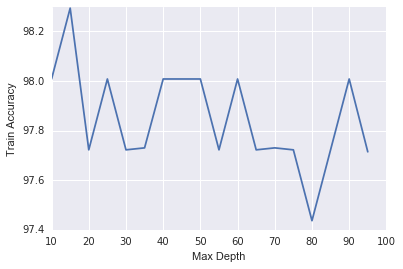

In [95]:
seed = 123

# RFC with fixed hyperparameters n_estimators, max_features and min_samples_leaf
rfc = RandomForestClassifier(n_jobs=-1, oob_score = True, n_estimators=36, max_features='sqrt', min_samples_leaf = 1) 

# Range of `max_depth` values to explore.
m_depth = filter(lambda x: x % 5 == 0, list(range(10,100)))

cv_scores = []

for j in m_depth:
    rfc.set_params(max_depth=j)
    #rfc.fit(train_x, train_y)
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    scores = model_selection.cross_val_score(rfc, train_x, train_y, cv=kfold, scoring='accuracy')
    cv_scores.append(scores.mean()*100)
    #print("n_estimator=%d %0.2f (+/- %0.2f)" % (j, scores.mean()*100, scores.std()*100))
    
optimal_depth = m_depth[cv_scores.index(max(cv_scores))]
print "The optimal maximum depth of a tree is %d with %0.1f%%" % (optimal_depth, cv_scores[optimal_depth])

plt.plot(m_depth, cv_scores)
plt.xlabel('Max Depth')
plt.ylabel('Train Accuracy')
plt.show()

Our results show a  improvement upon the model performance to 97.7% with max_depth of 15 and number of estimators equal to 36.subtle

The optimal minimum number of samples leaf is 2 with 98.0%


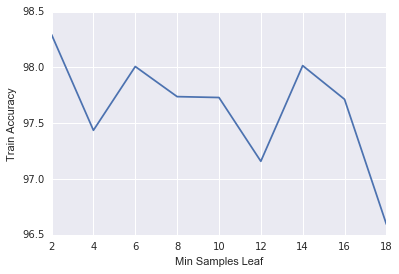

In [97]:
seed = 123
subtle
# RFC with fixed hyperparameters n_estimators, max_features and min_samples_leaf
rfc = RandomForestClassifier(n_jobs=-1, oob_score = True, n_estimators=36, max_features='sqrt', max_depth=15) 

# Range of `max_depth` values to explore.
m_sample = filter(lambda x: x % 2 == 0, list(range(1,20)))

cv_scores = []

for k in m_sample:
    rfc.set_params(min_samples_leaf=k)
    #rfc.fit(train_x, train_y)
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    scores = model_selection.cross_val_score(rfc, train_x, train_y, cv=kfold, scoring='accuracy')
    cv_scores.append(scores.mean()*100)
    #print("n_estimator=%d %0.2f (+/- %0.2f)" % (j, scores.mean()*100, scores.std()*100))
    
optimal_sample = m_sample[cv_scores.index(max(cv_scores))]
print "The optimal minimum number of samples leaf is %d with %0.1f%%" % (optimal_sample, cv_scores[optimal_sample])

plt.plot(m_sample, cv_scores)
plt.xlabel('Min Samples Leaf')
plt.ylabel('Train Accuracy')
plt.show()

Our results show that increasing the minimum number of samples leaf from 1 to 2 leads to a higher performance of 98%. In conclusion, searching the 3 hyperparameters one-by-one search leads to a top performance of 98.02% with n-estimators=36, max_depth=15 and min_samples_leaf=2.

Another approach using a Grid Search over the 3 parameters; n_estimators, max_depth, min_samples_leaf allows not to do an exhaustive and systematic search one parameter after another. We set up different ranges for each parameters including the aforementioned values. The results indicate a higher training performance of 98.02% with number of estimators = 36, max_depth = 5 and min_samples_leaf = 4. The model performance on test set is of 91.53% (less accurate than k-nearest neighbors algorithm).

In [101]:
from sklearn.grid_search import GridSearchCV
#from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_jobs=-1, max_features='sqrt', oob_score = True) 

# Use a grid over parameters of interest
param_grid = { 
           "n_estimators" : [9, 18, 27, 36, 45, 54, 63],
           "max_depth" : [1, 5, 10, 15, 20, 25, 30],
           "min_samples_leaf" : [1, 2, 4, 6, 8, 10]}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 10)
CV_rfc.fit(train_x, train_y)
print CV_rfc.best_params_
#print grid_search.cv_results_

{'n_estimators': 36, 'max_depth': 5, 'min_samples_leaf': 4}


In [104]:
seed = 123

# Optimized RF classifier
rfc = RandomForestClassifier(n_estimators=36, max_depth=5, max_features='sqrt', min_samples_leaf = 4)
rfc2 = RandomForestClassifier() # original and default RFC model

kfold = model_selection.KFold(n_splits=10, random_state=seed)

# fit the model with training set
scores = model_selection.cross_val_score(rfc2, train_x, train_y, cv=kfold, scoring='accuracy')
cv_scores.append(scores.mean()*100)
print("Train accuracy %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std()*100))

# predict on testing set
preds = model_selection.cross_val_predict(rfc2, test_x, test_y, cv=kfold)
cv_preds.append(metrics.accuracy_score(test_y, preds)*100)
print("Test accuracy %0.2f" % (100*metrics.accuracy_score(test_y, preds)))

Train accuracy 98.00 (+/- 2.57)
Test accuracy 95.76


The results indicated a training accuracy of 98.29% and a testing accuracy of 96.61%. We improved from the original training and testing model performance using default parameters, 98.00% and 95.76% respectively . In the next and last part, we will visit how to tune the hyperparameters of a support-vector machine model.

- Support Vector Machine

Consider plotting all your observations into a n-dimensional space (defined by n number of features) using their "unique" coordinates and where each observation is labeled by its class (e.g. begnin and malignant). Support Vector Machines are a class of discriminative algorithms that perform a classification on that n-dimensional space by finding the virtual line, also known as an hyperplane, that can separate their classes as best as possible. For example, if you had two features, you could represent all observations on a scatterplot and the algorithm would separate the classes by a line. By "best", the SVM algorithm searches for the largest minimum distance that separates observations from the two classes in the feature space - this is called the maximum margin. The margin is calculated as the perpendicular distance from the hyperplane to only the closest points. Only these points are relevant in defining the hyperplane and in the construction of the classifier. They are called the support vectors. 

http://www.datasciencecentral.com/profiles/blogs/learn-support-vector-machine-svm-from-scratch-in-r


In practice, real observations are messy and cannot be separated perfectly with a hyperplane. Therefore, the maximum margin must be more flexible allowing some observations (training set) to violate the hyperplane. A first tuning parameter is introduced called C (cost) that defines the amount of violation of the margin allowed. The larger the value of C is, the more violations of the hyperplane are permitted - the less sensitive the algorithm is to the training data (lower variance and higher bias).


The hyperplane that separates labeled observations can be linear and is defined by a linear equation. However, more often the hyperplane is not and requires a different set of functions to convert not separable input space to a separable higher dimensional space, these functions are called kernels. SVM have different types of kernels: linear, polynomial, radial basis and sigmoidal functions. If we pick a non-linear kernel function such as the radial basis function or 'rbf', a third tuning parameter must be considered, gamma. Gamma is the free parameter of the Gaussian radial basis function. If gamma is large, then variance is low implying the support vector does not have wide-spread influence (high bias).


In [108]:
from sklearn.grid_search import GridSearchCV
#from sklearn.ensemble import RandomForestClassifier

svc = SVC()

# Set the parameters by cross-validation
param_grid = { 
           "kernel" : ['linear', 'poly', 'rbf', 'sigmoid'],
           "gamma" : [1e-1, 1e-2, 1e-3, 1e-4],
           "C" : [1, 10, 100, 1000]}

CV_svc = GridSearchCV(estimator=svc, param_grid=param_grid, cv= 10)
CV_svc.fit(train_x, train_y)
print CV_svc.best_params_

{'kernel': 'rbf', 'C': 100, 'gamma': 0.001}


In [110]:
seed = 123

# Optimized RF classifier
svc = SVC(kernel='rbf', C=100, gamma=0.001)
svc2 = SVC() # original SVC model with default parameters: C=1, gamma='auto', kernel='rbf'

kfold = model_selection.KFold(n_splits=10, random_state=seed)

# fit the model with training set
scores = model_selection.cross_val_score(svc, train_x, train_y, cv=kfold, scoring='accuracy')
cv_scores.append(scores.mean()*100)
print("Train accuracy %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std()*100))

# predict on testing set
preds = model_selection.cross_val_predict(svc, test_x, test_y, cv=kfold)
cv_preds.append(metrics.accuracy_score(test_y, preds)*100)
print("Test accuracy %0.2f" % (100*metrics.accuracy_score(test_y, preds)))

Train accuracy 98.58 (+/- 1.91)
Test accuracy 94.07


- Logistic Regression

Definition

http://machinelearningmastery.com/logistic-regression-for-machine-learning/

In [112]:
seed = 123

# Optimized RF classifier

logreg2 = LogisticRegression() # original SVC model with default parameters: C=1, gamma='auto', kernel='rbf'

kfold = model_selection.KFold(n_splits=10, random_state=seed)

# fit the model with training set
scores = model_selection.cross_val_score(logreg2, train_x, train_y, cv=kfold, scoring='accuracy')
cv_scores.append(scores.mean()*100)
print("Train accuracy %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std()*100))

# predict on testing set
preds = model_selection.cross_val_predict(logreg2, test_x, test_y, cv=kfold)
cv_preds.append(metrics.accuracy_score(test_y, preds)*100)
print("Test accuracy %0.2f" % (100*metrics.accuracy_score(test_y, preds)))

Train accuracy 97.44 (+/- 2.37)
Test accuracy 92.37
